In [73]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
import glob 
import os

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, accuracy_score, precision_score, precision_recall_curve, f1_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

player_df = pd.read_json("data/1980-2018-per100-labeled.json")
player_df19 = pd.read_json("data/2019-per-100.json")
combined_df = pd.read_json("data/combined-player-team-stats.json")
combined_df19 = pd.read_json("data/2019-combined.json")

In [74]:
combined_df.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA_x', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA_x', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST_x', 'STL_x', 'BLK_x', 'TOV_x', 'PF_x', 'PTS_x',
       'ORtg', 'DRtg', 'Year', 'MVP', 'player_id', 'GP', 'WINS', 'LOSSES',
       'WIN_PCT', 'CONF_RANK', 'DIV_RANK', 'PO_WINS', 'PO_LOSSES',
       'CONF_COUNT', 'DIV_COUNT', 'NBA_FINALS_APPEARANCE', 'FGM', 'FGA_y',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA_y', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST_y', 'PF_y', 'STL_y', 'TOV_y', 'BLK_y', 'PTS_y',
       'PTS_RANK', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
       'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM',
       'DBPM', 'BPM', 'VORP'],
      dtype='object')

In [75]:
y_features = "MVP"
#x_features = ["Player","Year","Tm","MP","FG","FGA","3P","3PA","2P","2PA","FT","FTA","ORB","DRB","AST","STL","BLK","TOV","PF","PTS"]
x_features = ['Player','Year', 'Tm', 'MP', 'FG', 'FGA_x',
       '3P', '3PA', '2P', '2PA', 'FT', 'FTA_x', 'ORB',
       'DRB', 'TRB', 'AST_x', 'STL_x', 'BLK_x', 'TOV_x', 'PF_x', 'PTS_x',
       'ORtg', 'DRtg','WIN_PCT', 'CONF_RANK', 'USG%', 'WS']
#x_all = player_df[x_features]
x_all = combined_df[x_features]
#y_all = player_df[y_features]
y_all = combined_df[y_features]
# Drop the columns containing text data, leaving only numerical data
drop_txt = lambda x: x.drop(columns=["Player", "Year", "Tm"])
x_all_num = drop_txt(x_all)

In [76]:
x_old = x_all.loc[x_all.Year > 1980]
y_old = y_all.loc[x_all.Year > 1980]
x_19 = combined_df19[x_features]
x_19 = x_19[x_19['MP'] > 800]
x_train, x_test, y_train, y_test = train_test_split(x_old, y_old, test_size=0.3)

In [77]:
x_train_num = drop_txt(x_train)
x_test_num = drop_txt(x_test) 
x_old_num = drop_txt(x_old) 
x_new_num = drop_txt(x_19)
testing = False
show_pr_curves = False
if (not testing):
    x_train_num = x_old_num
    y_train = y_old

In [78]:
scale_pipe = lambda x: Pipeline([("scaler", StandardScaler()), x])
calibrate = lambda x: CalibratedClassifierCV(x, method='isotonic', cv=5)

In [79]:
xgb_calib = calibrate(XGBClassifier(learning_rate = 0.1, n_jobs=2, n_estimators=100))
xgb_uncalib = XGBClassifier(learning_rate = 0.1, n_jobs=2, n_estimators=100)
xgb_clf = scale_pipe(("xgb", xgb_calib))
xgb_clf_u = scale_pipe(("xgb", xgb_uncalib))
xgb_clf.fit(x_train_num, y_train)
xgb_clf_u.fit(x_train_num, y_train)
if (show_pr_curves):
    precf_gb, recf_gb, thrf_gb = precision_recall_curve(y_test, xgb_clf.predict_proba(x_test_num).transpose()[1], pos_label=1)
    plt.plot(recf_gb, precf_gb)
xgb_feat = xgb_clf_u.named_steps['xgb'].feature_importances_

In [80]:
xgb_pred_prob = xgb_clf.predict_proba(x_new_num).transpose()[1]
xgb_pred_indices = np.where(xgb_pred_prob > 0.1)

In [81]:
rf_calib = calibrate(RandomForestClassifier(n_jobs=2, n_estimators=400, max_features="auto"))
rf_uncalib = RandomForestClassifier(n_jobs=2,n_estimators=400, max_features="auto")
rf_clf = scale_pipe(("forest", rf_calib))
rf_clf_u = scale_pipe(("rf", rf_uncalib))
rf_clf.fit(x_train_num, y_train)
rf_clf_u.fit(x_train_num, y_train)
rf_pred_prob = rf_clf.predict_proba(x_new_num).transpose()[1]
if (show_pr_curves):
    precf_rf,recf_rf,thrf_rf = precision_recall_curve(y_test, rf_clf.predict_proba(x_test_num).transpose()[1], pos_label=1)
    plt.plot(recf_rf, precf_rf)
rf_feature_import = rf_clf_u.named_steps['rf'].feature_importances_

In [82]:
mlp = calibrate(MLPClassifier(solver='lbfgs', alpha = 1e-5,
                    hidden_layer_sizes=(100, 100)))
mlp_clf = scale_pipe(("mlp", mlp))
mlp_clf.fit(x_train_num, y_train)
mlp_pred_prob = mlp_clf.predict_proba(x_new_num).transpose()[1]
if (show_pr_curves):
    precf_rf,recf_rf,thrf_rf = precision_recall_curve(y_test, mlp_clf.predict_proba(x_test_num).transpose()[1], pos_label=1)
    plt.plot(recf_rf, precf_rf)

In [102]:
stacked_prob = np.mean([xgb_pred_prob, rf_pred_prob, 2*mlp_pred_prob], axis=0)
stacked_indices = np.where(stacked_prob > 0.01)
sum_prob = stacked_prob.sum()
x_19['Probability'] = stacked_prob/sum_prob
mvp_candiates = x_19.iloc[stacked_indices]
mvp_candidates = x_19.loc[x_19.Probability > 0.01]
mvp_candidates.to_json("data/mvp-prediction-2019.json")

In [103]:
mvp_summary = mvp_candiates.sort_values(by='Probability',ascending=False)[['Player','Probability']]
mvp_summary

,Player,Probability
294,James Harden,0.457406
88,Giannis Antetokounmpo,0.289234
102,Stephen Curry,0.119683
118,Nikola Jokic,0.032297
103,Kevin Durant,0.029669


In [104]:
x_19[x_19['MP'] > 1100].sort_values(by='Probability',ascending=False)

,Player,Year,Tm,MP,FG,FGA_x,3P,3PA,2P,2PA,FT,FTA_x,ORB,DRB,TRB,AST_x,STL_x,BLK_x,TOV_x,PF_x,PTS_x,ORtg,DRtg,WIN_PCT,CONF_RANK,USG%,WS,Probability
294,James Harden,2019,HOU,1980,14.0,31.8,6.6,17.6,7.4,14.2,13.3,15.3,1.3,7.5,8.8,10.2,2.9,1.0,7.0,4.3,48.0,119,109,0.589,5,40.2,10.4,0.457406
88,Giannis Antetokounmpo,2019,MIL,1719,14.1,24.2,0.8,3.5,13.3,20.7,9.2,12.9,3.2,14.6,17.7,8.3,2.0,2.0,5.5,4.9,38.2,119,98,0.750,1,31.9,10.2,0.289234
102,Stephen Curry,2019,GSW,1543,13.2,27.0,7.1,15.9,6.1,11.1,5.9,6.5,1.0,6.1,7.1,7.3,1.7,0.6,3.9,3.6,39.6,123,111,0.732,1,30.3,7.2,0.119683
118,Nikola Jokic,2019,DEN,1731,12.1,23.8,1.8,5.7,10.3,18.1,6.1,7.2,4.4,12.1,16.4,12.0,2.2,1.0,5.0,4.5,32.0,120,105,0.679,2,27.7,8.6,0.032297
103,Kevin Durant,2019,GSW,1984,13.0,25.3,2.4,6.8,10.5,18.6,8.5,9.5,0.7,8.8,9.4,8.0,1.1,1.4,4.2,2.6,36.9,120,109,0.732,1,30.2,8.6,0.029669
220,Kawhi Leonard,2019,TOR,1495,12.8,25.9,2.5,6.8,10.3,19.1,9.2,10.6,1.9,8.7,10.6,4.6,2.6,0.6,2.9,2.1,37.2,121,105,0.724,2,29.8,7.2,0.015538
47,Anthony Davis,2019,NOP,1602,13.1,25.7,1.2,3.7,11.9,22.1,9.4,11.6,4.2,12.7,16.9,5.5,2.1,3.3,2.5,3.4,36.7,124,105,0.431,13,29.5,8.8,0.013825
215,Nikola Vucevic,2019,ORL,1777,13.6,26.2,1.8,4.6,11.9,21.5,3.2,4.2,4.2,14.7,18.9,6.0,1.5,1.8,3.1,3.0,32.3,114,104,0.448,10,27.8,6.9,0.013825
190,Joel Embiid,2019,PHI,1788,12.6,26.1,1.7,5.7,10.9,20.4,11.4,14.0,3.5,15.4,18.8,4.9,0.8,2.7,5.0,4.7,38.2,113,104,0.632,5,33.2,7.1,0.013825
223,Paul George,2019,OKC,1993,12.1,26.6,5.0,12.1,7.1,14.4,7.6,9.1,1.8,8.4,10.3,5.3,3.0,0.6,3.4,3.6,36.7,119,103,0.661,3,29.7,9.8,0.004875


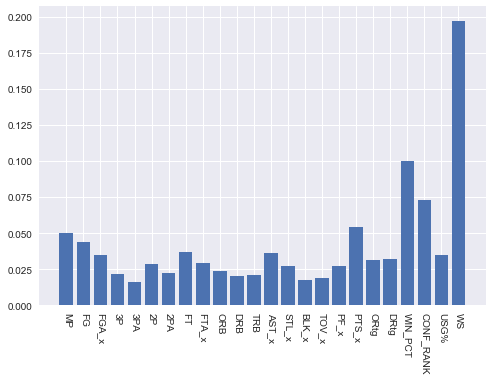

<BarContainer object of 24 artists>

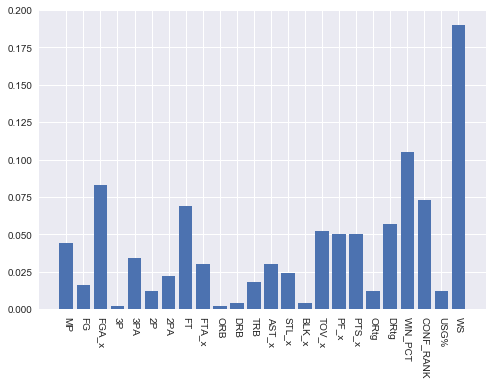

In [94]:
plt.xticks(rotation=-90)
plt.bar(x_features[3:], rf_feature_import)
plt.show()
plt.xticks(rotation=-90)
plt.bar(x_features[3:], xgb_feat)

In [87]:
import umap
embedding = umap.UMAP(n_neighbors=100, min_dist = 0.5).fit_transform(x_old_num)

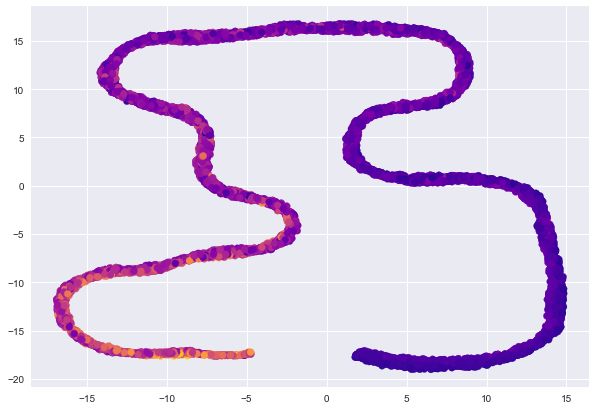

In [93]:
plt.style.use('seaborn')
plt.figure(figsize=(10,7))
plt.scatter(embedding[:, 0], embedding[:, 1], c=x_old_num['WS'], cmap="plasma")